In [50]:
import xarray as xr
import os
import pandas as pd
import tqdm
import dask
import numpy as np
from dask.delayed import delayed
from dask.diagnostics import ProgressBar
from collections import OrderedDict
from itertools import product
import os
import math
from netCDF4 import Dataset
from cdo import *   # python version
cdo = Cdo()
import matplotlib.pylab as plt
%matplotlib inline

In [58]:
# parameters cell
input_paths = ['/p/scratch/chhb19/jstreffi/runtime/awicm-3.1/MASS/outdata/oifs/links_combined_with_SPIN',
               '/p/scratch/chhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/oifs/links_combined_with_SPIN']

input_names = ['MASS', 'HIST']
climatology_path = ['/p/project/chhb19/streffing1/obs/era5/netcdf/']
accumulation_period = 21600 # output frequency of OpenIFS in seconds
exps = range(1, 3)
figsize=(8, 4)
dpi = 300
smooth_window = 5
ofile = None
var = ['SSR', 'STR', 'TSR', 'TTR', 'SLHF', 'SSHF'] 
#var must have order:  
#1. Surface net solar radiation
#2. Surface net thermal radiation
#3. Top net solar radiation
#4. Top net thermal radiation

In [52]:
def smooth(x,beta,smooth_window):
    """ kaiser window smoothing """
    window_len=2*smooth_window+1
    beta=2*smooth_window
    # extending the data at beginning and at the end
    # to apply the window at the borders
    s = np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w = np.kaiser(window_len,beta)
    y = np.convolve(w/w.sum(),s,mode='valid')
    return y[smooth_window:len(y)-smooth_window]

def define_rowscol(input_paths, columns=len(input_paths), reduce=0):
    number_paths = len(input_paths) - reduce
#     columns = columns
    if number_paths < columns:
        ncol = number_paths
    else:
        ncol = columns
    nrows = math.ceil(number_paths / columns)
    return [nrows, ncol]

In [53]:
# Load model Data

data = OrderedDict()
for 
for v in var:
    paths = []
    data[v] = []
    for exp in tqdm.tqdm(exps):
        path = input_paths[0]+'/'+v+'_'+f'{exp:05d}.nc'
        data[v].append(cdo.yearmean(input="-fldmean "+str(path),returnArray=v)/accumulation_period)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.14it/s]


In [54]:
print(type(data[v]))

<class 'list'>


In [55]:
surface =   np.squeeze(data['SSR']).flatten() + \
            np.squeeze(data['STR']).flatten() + \
            np.squeeze(data['SSHF']).flatten() + \
            np.squeeze(data['SLHF']).flatten()
toa = np.squeeze(data['TSR']).flatten() + \
      np.squeeze(data['TTR']).flatten()

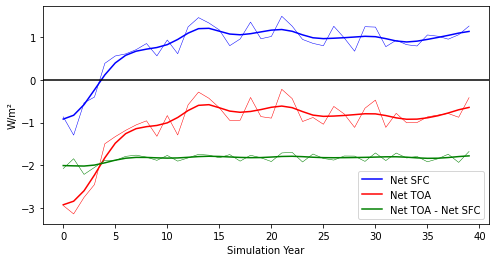

In [59]:
fig, axes = plt.subplots(figsize=figsize)

plt.plot(smooth(surface,len(surface),smooth_window),color='blue')
plt.plot(smooth(toa,len(toa),smooth_window),color='red')
plt.plot(smooth(toa-surface,len(toa-surface),smooth_window),color='green')
#axes.tick_params(labelright=True)

plt.plot(surface,linewidth=0.5,color='blue')
plt.plot(toa,linewidth=0.5,color='red')
plt.plot(toa-surface,linewidth=0.5,color='green')


plt.axhline(y=0, color='black', linestyle='-')
plt.ylabel('W/m²')
plt.xlabel('Simulation Year')

axes.legend(['Net SFC', 'Net TOA', 'Net TOA - Net SFC'])


if ofile is not None:
    ofile_long = f"{ofile}_imbalance_combined.png"
    plt.savefig(f"{ofile_long}", dpi=dpi)
    os.system(f'convert {ofile_long} -trim {ofile_long}_trimmed.png')
    os.system(f'mv {ofile_long}_trimmed.png {ofile_long}')